# SJSU MSDS 255 DL, Spring 2024
Homework 07: NLP

Git: https://github.com/jrgosalvez/data255_DL

In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import re
import nltk
from nltk.corpus import stopwords

### Step 1: Load the Wikipedia GLoVE Word2Vec (glove.6B.50d.txt)

Download GLoVe pretrained models: https://nlp.stanford.edu/projects/glove/

In [2]:
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word   = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

#### Create functions

In [3]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

In [4]:
def analogy(wordvec1, wordvec2, wordvec3):
    analogy = find_closest_embeddings(embeddings_dict[wordvec1] - embeddings_dict[wordvec3] + embeddings_dict[wordvec2])[1:2]
    return analogy[0]

#### Experimenting

In [5]:
# Find closest three words without returning the word itself
find_closest_embeddings(embeddings_dict["king"])[1:4]

['prince', 'queen', 'uncle']

In [6]:
print(find_closest_embeddings(
    embeddings_dict["king"] - embeddings_dict["man"] + embeddings_dict["woman"]
)[1:4])

['queen', 'prince', 'elizabeth']


In [7]:
print(find_closest_embeddings(
    embeddings_dict["princess"] - embeddings_dict["woman"] + embeddings_dict["man"]
)[1:2])

['prince']


In [8]:
analogy("princess", "man", "woman")

'prince'

### Step 2: Show how similar these words are:
- Man and Woman
- Chair and Throne
- water and baby

In [9]:
def similar(wordvec1, wordvec2):
    # Get the embeddings for "wordvec1"
    embedding = embeddings_dict[wordvec1].reshape(1, -1)

    # Get embeddings for the predicted words
    predicted_words = [wordvec2]
    predicted_embeddings = [embeddings_dict[word] for word in predicted_words]

    # Calculate cosine similarity
    similarities = cosine_similarity(embedding, predicted_embeddings)

    # Print the cosine similarity scores
    for word, similarity_score in zip(predicted_words, similarities[0]):
        print(f"Cosine similarity between {wordvec1} and {word}: {similarity_score:.4f}")
        
similar("man", "woman")
similar("chair", "throne")
similar("water", "baby")

Cosine similarity between man and woman: 0.8860
Cosine similarity between chair and throne: 0.2797
Cosine similarity between water and baby: 0.4081


### Step 3: Using these provide analogies for the following:

- _____ is to King as Woman is to Man.
- _____ is to Princess as Man is to Woman.
- _____ is to a woman as a child is to an adult.

In [10]:
# Define analogy examples
analogies = [
    ("king", "woman", "man"),
    ("princess", "man", "woman"),
    ("woman", "child", "adult")
]

# Calculate and print analogies
for analogy_pair in analogies:
    analogy_word = analogy(*analogy_pair)
    print(f"'{analogy_word}' is to '{analogy_pair[0]}' as '{analogy_pair[1]}' is to '{analogy_pair[2]}'")

'queen' is to 'king' as 'woman' is to 'man'
'prince' is to 'princess' as 'man' is to 'woman'
'mother' is to 'woman' as 'child' is to 'adult'


### Step 4: Apply Naive-Bayes Classifier on the Spam-Ham dataset shown in the demo

In [11]:
# Load the Spam-Ham dataset
data = pd.read_csv("spam.csv", encoding='latin-1')

data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


- v1 = target / labels
- v2 = text to pre-process and use

#### Preparing and exploring preprocessed spam-ham data

In [12]:
# Preprocess the text
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = text.lower()  # Convert text to lowercase
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

data['clean_text'] = data['v2'].apply(preprocess_text)

In [13]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,nah think goes usf lives around though


#### Split the dataset into train and test sets 80/20

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['v1'], test_size=0.2, random_state=42)

#### Vectorize data for model ingestion by convert texting data to numerical features using CountVectorizer

In [15]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts  = vectorizer.transform(X_test)

#### Train the Naive-Bayes Classifier

In [16]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_counts, y_train)

MultinomialNB()

### Evaluate the classifier

In [17]:
y_pred = nb_classifier.predict(X_test_counts)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9821


confusion_matrix:  [[959   6]
 [ 14 136]]


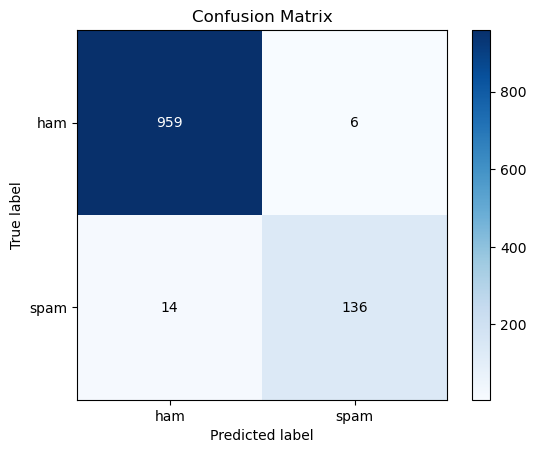

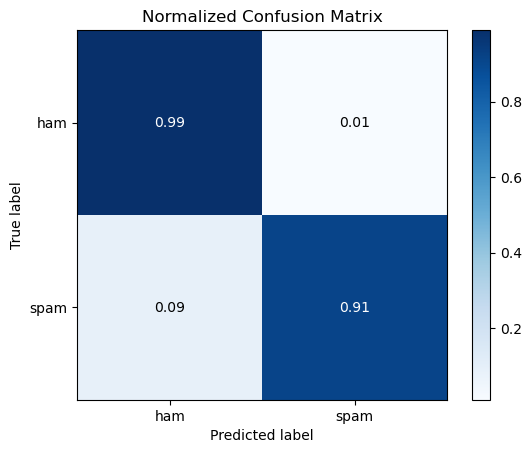

In [18]:
#confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred, labels=["ham","spam"])
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

print('confusion_matrix: ', confusion_matrix)
plt.show()